# Modelling Analysis
## Summary of this analysis
### Logistic regression
Here I use logistic regression as a benchmark model. This model is quite simple and computationally light but at the same time, it doesn't work well with imbalanced data. The F1-score for test set is 0.33, which looks so much space to be improved.

### Random undersampling + Boosting
This algorithm can balance the class imbalance at each iteration of the boosting algorithm, so that it can learn proper class balance. Also this algorithm uses decision tree as a base learner. Tree-based algorithms are generally good at learning the relations of complex features.

The results show that it improved a lot comparison to logistic regression. This model flagged more customers that logistic regression model but precision decreased (the number of false positive increased).

### XGBoost model
Use XGBoost to improve the model performance. The advantages of this algorithm are:
1. it is a tree-based model so that it can capture the complex relations of features
2. Also a tree-based model are better at dealing with imbalanced data
3. it is a boosting algorithm so that it is more robust to over-fitting 
4. it can produce the feature importance list
5. it works also well with small dataset
6. there are many parameters to tune

The result shows that this model's F1 score is 0.5606 on the test set, which is so much improvement from the previous models. The confusion matrix is below.

| Actual\Prediction | Lapse       | Not lapse|
| :---              |    :----:   |   :---:  |
| Lapse             | 28907       | 11972    |
| Not lapse         | 4936        | 10787    |

From this confusion matrix, we can see that recall is higher - and lower precision. 



### 1D-CNN model
This architecture is known with supreme predictive power. I was expecting with this model, it will improve the model performance but it was slightly worse than XGBoost model. Also due to time constrain, I didn't have time to fine-tune the model so it might be also the reason. 


### Prediction and Evaluation
With XGBoost, the model performance improved to RMSE = 0.8167 with log value of preparation time in seconds. To be used in the business (easier interpretation), it needs to be transformed back to normal values. Also I think it is more usable to have the prediction in mins so I will transform it into mins. For further interpretability, I will evaluate the performance in mean absolute error (MAE).

After transformed them into mins, the model showed that in average, there are 12.0 mins error, which seems quite big error for the business use case. However, considering 75% of orders are prepared within 1227 seconds (21 mins) and 95% of orders within 3021 seconds (50 mins), taking longer than those time would be assumed as outliers. Thus, I evaluate those orders which took less than 21 mins and 60 mins. The results are MAE = 4 mins and MAE = 5 mins, respectively.

### Next steps
As we have seen, quite a few outliers made this prediction more difficult. I guess those outliers are coming from several resons such as some accidents in the kitchen, some human errors (forgot to prepare the order), etc. So I would assume it would be difficult to predict. But we know these kind of things would happen with some probability (we are all human after all). If we could have much more data, we could build one more layer that would classify an order will take more than x mins, where x could be like 50 mins (if it"s so important to have precise predictions for those outliers as a business). Also if we had more data, we could build a more complex model, namely neural network model so that it might be able to capture those outlier information better than XGBoost model.

Potentially, this model can be consumed by the team working on logistics. If we could have precise predictions of preparation time, the logistics team can inform the users the precise estimate of delivery time and also can optimise the riders" logistics. As riders do not have to wait at the restaurant to "waste" their time to deliver orders.

## Table of contents
[Prepare the input features](#Prepare-the-input-features)

[Logistic regression](#Logistic-regression)

[XGBoost](#XGBoost)
- [Hyperparameter tuning](#Hyperparameter-tuning)
- [Train](#Train)
- [Prediction and Evaluation](#Prediction-and-Evaluation)

[Next steps](#Next-steps)


In [84]:
import os
import numpy as np
import pandas as pd
import logging
import warnings
import shap
from datetime import datetime
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from imblearn.ensemble import RUSBoostClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix, auc
import xgboost as xgb
from tensorflow import keras
from tensorflow.keras import layers
import seaborn as sns
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [2]:
os.chdir("/Users/kyosuke/projects/home-insurance/")

In [3]:
pd.options.display.max_rows = None
pd.options.display.max_columns = None

In [4]:
df = pd.read_csv("resources/data/home_insurance.csv")

## Prepare the input features

In [5]:
def prepareInputs(df: "pd.dataFrame") -> "pd.dataFrame":
    """Prepare the input for training

    Args:
        df (pd.DataFrame): raw data
        
    Process:
        1. Exclude missing values
        2. Clean the target variable
        3. Create dummy variables for categorical variables
        4. Create age features
        5. Impute missing value
    
    Return: pd.dataFrame
    """
    
    # 1. Exclude missing values
    df = df[df["POL_STATUS"].notnull()]
    
    # 2. Clean the target variable
    df = df[df["POL_STATUS"] != "Unknown"]
    df["lapse"] = np.where(df["POL_STATUS"] == "Lapsed", 1, 0)
    
    # 3. Create dummy variables for categorical variables
    categorical_cols = ["CLAIM3YEARS", "BUS_USE", "AD_BUILDINGS",
                        "APPR_ALARM", "CONTENTS_COVER", "P1_SEX",
                        "BUILDINGS_COVER", "P1_POLICY_REFUSED", 
                        "APPR_LOCKS", "FLOODING",
                        "NEIGH_WATCH", "SAFE_INSTALLED", "SEC_DISC_REQ",
                        "SUBSIDENCE", "LEGAL_ADDON_POST_REN", 
                        "HOME_EM_ADDON_PRE_REN","HOME_EM_ADDON_POST_REN", 
                        "GARDEN_ADDON_PRE_REN", "GARDEN_ADDON_POST_REN", 
                        "KEYCARE_ADDON_PRE_REN", "KEYCARE_ADDON_POST_REN", 
                        "HP1_ADDON_PRE_REN", "HP1_ADDON_POST_REN",
                        "HP2_ADDON_PRE_REN", "HP2_ADDON_POST_REN", 
                        "HP3_ADDON_PRE_REN", "HP3_ADDON_POST_REN", 
                        "MTA_FLAG", "OCC_STATUS", "OWNERSHIP_TYPE",
                        "PROP_TYPE", "PAYMENT_METHOD", "P1_EMP_STATUS",
                        "P1_MAR_STATUS"
                        ]
    
    for col in categorical_cols:
        dummies = pd.get_dummies(df[col], 
                                 drop_first = True,
                                 prefix = col
                                )
        df = pd.concat([df, dummies], 1)
    
    # 4. Create age features
    df["age"] = (datetime.strptime("2013-01-01", "%Y-%m-%d") - pd.to_datetime(df["P1_DOB"])).dt.days // 365
    df["property_age"] = 2013 - df["YEARBUILT"]
    df["cover_length"] = 2013 - pd.to_datetime(df["COVER_START"]).dt.year
    
    # 5. Impute missing value
    df["RISK_RATED_AREA_B_imputed"] = df["RISK_RATED_AREA_B"].fillna(df["RISK_RATED_AREA_B"].mean())
    df["RISK_RATED_AREA_C_imputed"] = df["RISK_RATED_AREA_C"].fillna(df["RISK_RATED_AREA_C"].mean())
    df["MTA_FAP_imputed"] = df["MTA_FAP"].fillna(0)
    df["MTA_APRP_imputed"] = df["MTA_APRP"].fillna(0)

    return df

In [87]:
# FEATS = [
#          "CLAIM3YEARS_Y", "BUS_USE_Y", "AD_BUILDINGS_Y",
#          "CONTENTS_COVER_Y", "P1_SEX_M", "P1_SEX_N", "BUILDINGS_COVER_Y", 
#          "P1_POLICY_REFUSED_Y", "APPR_ALARM_Y", "APPR_LOCKS_Y", "FLOODING_Y", 
#          "NEIGH_WATCH_Y", "SAFE_INSTALLED_Y", "SEC_DISC_REQ_Y", "SUBSIDENCE_Y", 
#          "LEGAL_ADDON_POST_REN_Y", "HOME_EM_ADDON_PRE_REN_Y", 
#          "HOME_EM_ADDON_POST_REN_Y", "GARDEN_ADDON_PRE_REN_Y",
#          "GARDEN_ADDON_POST_REN_Y", "KEYCARE_ADDON_PRE_REN_Y", 
#          "KEYCARE_ADDON_POST_REN_Y", "HP1_ADDON_PRE_REN_Y", "HP1_ADDON_POST_REN_Y", 
#          "HP2_ADDON_PRE_REN_Y", "HP2_ADDON_POST_REN_Y", "HP3_ADDON_PRE_REN_Y", 
#          "HP3_ADDON_POST_REN_Y", "MTA_FLAG_Y", "OCC_STATUS_LP",
#          "OCC_STATUS_PH", "OCC_STATUS_UN", "OCC_STATUS_WD",
#          "OWNERSHIP_TYPE_2.0", "OWNERSHIP_TYPE_3.0", "OWNERSHIP_TYPE_6.0", 
#          "OWNERSHIP_TYPE_7.0", "OWNERSHIP_TYPE_8.0", "OWNERSHIP_TYPE_11.0", 
#          "OWNERSHIP_TYPE_12.0", "OWNERSHIP_TYPE_13.0", "OWNERSHIP_TYPE_14.0", 
#          "OWNERSHIP_TYPE_16.0", "OWNERSHIP_TYPE_17.0", 
#          "OWNERSHIP_TYPE_18.0", "PROP_TYPE_2.0", "PROP_TYPE_3.0", "PROP_TYPE_4.0", 
#          "PROP_TYPE_7.0", "PROP_TYPE_9.0", "PROP_TYPE_10.0", 
#          "PROP_TYPE_16.0", "PROP_TYPE_17.0", "PROP_TYPE_18.0", "PROP_TYPE_19.0", 
#          "PROP_TYPE_20.0", "PROP_TYPE_21.0", "PROP_TYPE_22.0", "PROP_TYPE_23.0", 
#          "PROP_TYPE_24.0", "PROP_TYPE_25.0", "PROP_TYPE_26.0", "PROP_TYPE_27.0", 
#          "PROP_TYPE_29.0", "PROP_TYPE_30.0", "PROP_TYPE_31.0", 
#          "PROP_TYPE_32.0", "PROP_TYPE_37.0", "PROP_TYPE_39.0", 
#          "PROP_TYPE_40.0", "PROP_TYPE_44.0", "PROP_TYPE_45.0", "PROP_TYPE_47.0", 
#          "PROP_TYPE_48.0", "PROP_TYPE_51.0", "PROP_TYPE_52.0", "PROP_TYPE_53.0", 
#          "PAYMENT_METHOD_NonDD", "PAYMENT_METHOD_PureDD", "P1_EMP_STATUS_C", 
#          "P1_EMP_STATUS_E", "P1_EMP_STATUS_F", "P1_EMP_STATUS_H", "P1_EMP_STATUS_I", 
#          "P1_EMP_STATUS_N", "P1_EMP_STATUS_R", "P1_EMP_STATUS_S", "P1_EMP_STATUS_U", 
#          "P1_EMP_STATUS_V", "P1_MAR_STATUS_B", "P1_MAR_STATUS_C", "P1_MAR_STATUS_D", 
#          "P1_MAR_STATUS_M", "P1_MAR_STATUS_N", "P1_MAR_STATUS_O", "P1_MAR_STATUS_P", 
#          "P1_MAR_STATUS_S", "P1_MAR_STATUS_W", 
#          "age", "property_age", "cover_length", "RISK_RATED_AREA_B_imputed", 
#          "RISK_RATED_AREA_C_imputed", "MTA_FAP_imputed", "MTA_APRP_imputed",
#          "SUM_INSURED_BUILDINGS", "NCD_GRANTED_YEARS_B", "SUM_INSURED_CONTENTS", 
#          "NCD_GRANTED_YEARS_C", "SPEC_SUM_INSURED", "SPEC_ITEM_PREM", 
#          "UNSPEC_HRP_PREM", "BEDROOMS", "MAX_DAYS_UNOCC", "LAST_ANN_PREM_GROSS"
#         ]

In [6]:
FEATS = [
        'P1_MAR_STATUS_P', 'PAYMENT_METHOD_NonDD', 'AD_BUILDINGS_Y',
        'HOME_EM_ADDON_POST_REN_Y', 'KEYCARE_ADDON_PRE_REN_Y', 'MAX_DAYS_UNOCC',
        'HP1_ADDON_POST_REN_Y', 'HP2_ADDON_POST_REN_Y',
        'LEGAL_ADDON_POST_REN_Y', 'PAYMENT_METHOD_PureDD',
        'HP3_ADDON_POST_REN_Y', 'GARDEN_ADDON_PRE_REN_Y',
        'GARDEN_ADDON_POST_REN_Y', 'KEYCARE_ADDON_POST_REN_Y',
        'SUM_INSURED_BUILDINGS', 'HOME_EM_ADDON_PRE_REN_Y', 'OCC_STATUS_LP',
        'P1_MAR_STATUS_O', 'OCC_STATUS_PH', 'PROP_TYPE_51.0', 'PROP_TYPE_2.0',
        'NCD_GRANTED_YEARS_B', 'MTA_FLAG_Y', 'cover_length', 'PROP_TYPE_22.0',
        'BUILDINGS_COVER_Y', 'SUBSIDENCE_Y', 'NCD_GRANTED_YEARS_C',
        'RISK_RATED_AREA_C_imputed', 'RISK_RATED_AREA_B_imputed',
        'SAFE_INSTALLED_Y', 'FLOODING_Y', 'P1_MAR_STATUS_C', 'PROP_TYPE_18.0',
        'UNSPEC_HRP_PREM', 'SUM_INSURED_CONTENTS', 'PROP_TYPE_32.0',
        'LAST_ANN_PREM_GROSS', 'PROP_TYPE_53.0', 'SPEC_ITEM_PREM',
        'MTA_FAP_imputed', 'P1_MAR_STATUS_D', 'HP2_ADDON_PRE_REN_Y',
        'P1_MAR_STATUS_M', 'MTA_APRP_imputed', 'PROP_TYPE_16.0',
        'PROP_TYPE_17.0', 'PROP_TYPE_48.0', 'SPEC_SUM_INSURED',
        'PROP_TYPE_47.0', 'PROP_TYPE_4.0', 'P1_EMP_STATUS_H', 'P1_EMP_STATUS_U',
        'P1_EMP_STATUS_S', 'CLAIM3YEARS_Y', 'OWNERSHIP_TYPE_7.0',
        'PROP_TYPE_45.0', 'BUS_USE_Y', 'P1_EMP_STATUS_N', 'property_age',
        'P1_MAR_STATUS_S', 'PROP_TYPE_7.0', 'PROP_TYPE_9.0', 'PROP_TYPE_19.0',
        'PROP_TYPE_25.0', 'P1_MAR_STATUS_W', 'age', 'APPR_ALARM_Y', 'BEDROOMS',
        'PROP_TYPE_26.0', 'OCC_STATUS_UN', 'P1_EMP_STATUS_R', 'SEC_DISC_REQ_Y',
        'OWNERSHIP_TYPE_18.0', 'P1_EMP_STATUS_E', 'OWNERSHIP_TYPE_3.0',
        'OWNERSHIP_TYPE_12.0', 'APPR_LOCKS_Y', 'OWNERSHIP_TYPE_14.0',
        'OWNERSHIP_TYPE_8.0', 'OWNERSHIP_TYPE_13.0', 'PROP_TYPE_10.0',
        'NEIGH_WATCH_Y', 'PROP_TYPE_31.0', 'PROP_TYPE_52.0', 'P1_SEX_M',
        'OWNERSHIP_TYPE_2.0'
        ]

In [7]:
# Split train and test
train, test = train_test_split(df, test_size = .3, random_state = 42)

In [8]:
train, test = prepareInputs(train), prepareInputs(test)

In [9]:
X_train, y_train, X_test, y_test = train[FEATS], train["lapse"], test[FEATS], test["lapse"]

In [10]:
# Standardise the data sets
numerical_cols = [
    "age", "property_age", "cover_length", "RISK_RATED_AREA_B_imputed", 
    "RISK_RATED_AREA_C_imputed", "MTA_FAP_imputed", "MTA_APRP_imputed",
    "SUM_INSURED_BUILDINGS", "NCD_GRANTED_YEARS_B", "SUM_INSURED_CONTENTS", 
    "NCD_GRANTED_YEARS_C", "SPEC_SUM_INSURED", "SPEC_ITEM_PREM", 
    "UNSPEC_HRP_PREM", "BEDROOMS", "MAX_DAYS_UNOCC", "LAST_ANN_PREM_GROSS"
]

for col in numerical_cols:
    scaler = StandardScaler()

    X_train[col] = scaler.fit_transform(X_train[[col]])
    X_test[col] = scaler.transform(X_test[[col]])

In [11]:
print("The ratio of lapse class in training set is " +
      str(round(y_train.sum()/len(y_train) * 100, 2)) +
      "%"
     )

print("The ratio of lapse class in test set is " +
      str(round(y_test.sum()/len(y_test)* 100, 2)) +
      "%"
     )

The ratio of lapse class in training set is 27.8%
The ratio of lapse class in test set is 27.78%


## Logistic regression
Here I use logistic regression as a benchmark model. This model is quite simple and computationally light but at the same time, it doesn't work well with imbalanced data. The F1-score for test set is 0.33, which looks so much space to be improved.

In [12]:
logit = LogisticRegression(random_state = 42).fit(X_train, y_train)

prediction_train = logit.predict(X_train)
prediction = logit.predict(X_test)

In [13]:
print("Accuracy for training set is " + str(round(accuracy_score(y_train, prediction_train),4)))
print("Accuracy for test set is " + str(round(accuracy_score(y_test, prediction),4)))

Accuracy for training set is 0.7415
Accuracy for test set is 0.7435


In [14]:
print("F1 score for training set is " + str(round(f1_score(y_train, prediction_train),4)))
print("F1 score for test set is " + str(round(f1_score(y_test, prediction),4)))

F1 score for training set is 0.3208
F1 score for test set is 0.3301


In [15]:
confusion_matrix(y_test, prediction)

array([[38506,  2373],
       [12146,  3577]])

## Random undersampling + Boosting
This algorithm can balance the class imbalance at each iteration of the boosting algorithm, so that it can learn proper class balance. Also this algorithm uses decision tree as a base learner. Tree-based algorithms are generally good at learning the relations of complex features.

The results show that it improved a lot comparison to logistic regression. This model flagged more customers that logistic regression model but precision decreased (the number of false positive increased).

In [71]:
rusboost = RUSBoostClassifier(random_state = 42)

rusboost.fit(X_train, y_train)

prediction_train_rusb = rusboost.predict(X_train)
prediction_rusb = rusboost.predict(X_test)

In [72]:
print("Accuracy for training set is " + str(round(accuracy_score(y_train, prediction_train_rusb),4)))
print("Accuracy for test set is " + str(round(accuracy_score(y_test, prediction_rusb),4)))

Accuracy for training set is 0.6654
Accuracy for test set is 0.6649


In [73]:
print("F1 score for training set is " + str(round(f1_score(y_train, prediction_train_rusb),4)))
print("F1 score for test set is " + str(round(f1_score(y_test, prediction_rusb),4)))

F1 score for training set is 0.5265
F1 score for test set is 0.5276


In [74]:
confusion_matrix(y_test, prediction_rusb)

array([[27040, 13839],
       [ 5131, 10592]])

## XGBoost model
Use XGBoost to improve the model performance. The advantages of this algorithm are:
1. it is a tree-based model so that it can capture the complex relations of features
2. Also a tree-based model are better at dealing with imbalanced data
3. it is a boosting algorithm so that it is more robust to over-fitting 
4. it can produce the feature importance list
5. it works also well with small dataset
6. there are many parameters to tune

## Hyperparameter tuning

In [17]:
search_params = [
    (eta,max_depth,min_child_weight,
    subsample,objective,eval_metric,
    grow_policy)
    for eta in [i/100. for i in range(1,3,1)]
    for max_depth in range(6, 12, 2)
    for min_child_weight in range(5,8,1)
    for subsample in [i/10. for i in range(5,7,1)]
    for objective in ['binary:logistic']
    for eval_metric in ['auc', 'logloss', 'error']
    for grow_policy in ['depthwise','lossguide']
]

In [18]:
# Default parameters to be updated
params = {
            'eta': .03,
            'max_depth': 8,
            'min_child_weight': 0,
            'subsample': 1,
            'objective': 'binary:logistic',
            'eval_metric': 'logloss',
            'grow_policy': 'depthwise'
        }

In [19]:
print("number of parameters is " + str(len(search_params)))

number of parameters is 216


In [20]:
boost_rounds = 500
min_error = float("Inf")
best_params = None

for eta, max_depth, min_child_weight,subsample,objective,eval_metric,grow_policy in search_params:
    print("CV with eta={}, max_depth={}, min_child_weight={}, subsample={}, objective={}, eval_metric={}, grow_policy={}".format(
        eta,
        max_depth,
        min_child_weight,
        subsample,
        objective,
        eval_metric,
        grow_policy
    ))
    
    # Update parameters
    params['eta'] = eta
    params['max_depth'] = max_depth
    params['min_child_weight'] = min_child_weight
    params['subsample'] = subsample
    params['objective'] = objective
    params['eval_metric'] = eval_metric
    params['grow_policy'] = grow_policy

    # Run CV
    cv_results = xgb.cv(
        params,
        xgb.DMatrix(X_train, y_train),
        seed=42,
        nfold=5,
        metrics=['error'],
        early_stopping_rounds=10
    )
    
    # Update best error score
    mean_error = cv_results['test-error-mean'].min()
    print("\tError {} for {} rounds".format(mean_error, boost_rounds))
    if mean_error < min_error:
        min_error = mean_error
        best_params = (eta,max_depth,min_child_weight,subsample,objective,eval_metric,grow_policy)
        
        params = {
            'eta': best_params[0],
            'max_depth': best_params[1],
            'min_child_weight': best_params[2],
            'subsample': best_params[3],
            'objective': best_params[4],
            'eval_metric': best_params[5],
            'grow_policy': best_params[6]
        }
        
print("Best params: eat={}, max_depth={}, min_child_weight={},\
        subsample={}, objective={}, eval_metric={}, grow_policy={},\
        Error: {}".format(best_params[0], best_params[1],best_params[2], best_params[3],best_params[4],best_params[5], best_params[6], min_error))

CV with eta=0.01, max_depth=6, min_child_weight=5, subsample=0.5, objective=binary:logistic, eval_metric=auc, grow_policy=depthwise
	Error 0.2600924 for 500 rounds
CV with eta=0.01, max_depth=6, min_child_weight=5, subsample=0.5, objective=binary:logistic, eval_metric=auc, grow_policy=lossguide
	Error 0.2600924 for 500 rounds
CV with eta=0.01, max_depth=6, min_child_weight=5, subsample=0.5, objective=binary:logistic, eval_metric=logloss, grow_policy=depthwise
	Error 0.2600924 for 500 rounds
CV with eta=0.01, max_depth=6, min_child_weight=5, subsample=0.5, objective=binary:logistic, eval_metric=logloss, grow_policy=lossguide
	Error 0.2600924 for 500 rounds
CV with eta=0.01, max_depth=6, min_child_weight=5, subsample=0.5, objective=binary:logistic, eval_metric=error, grow_policy=depthwise
	Error 0.2600924 for 500 rounds
CV with eta=0.01, max_depth=6, min_child_weight=5, subsample=0.5, objective=binary:logistic, eval_metric=error, grow_policy=lossguide
	Error 0.2600924 for 500 rounds
CV w

In [21]:
params

{'eta': 0.02,
 'max_depth': 10,
 'min_child_weight': 7,
 'subsample': 0.6,
 'objective': 'binary:logistic',
 'eval_metric': 'error',
 'grow_policy': 'lossguide'}

## Train

In [22]:
dtrain, dtest = xgb.DMatrix(X_train, y_train, feature_names=FEATS), xgb.DMatrix(X_test, y_test, feature_names=FEATS)

ROUNDS = 500
EVAL_LIST = [(dtrain, "train"),(dtest, "test")]

xgb_model = xgb.train(params,dtrain,ROUNDS,EVAL_LIST)

[0]	train-error:0.24889	test-error:0.25142
[1]	train-error:0.24546	test-error:0.24773
[2]	train-error:0.24406	test-error:0.24679
[3]	train-error:0.24407	test-error:0.24580
[4]	train-error:0.24280	test-error:0.24538
[5]	train-error:0.24268	test-error:0.24591
[6]	train-error:0.24265	test-error:0.24526
[7]	train-error:0.24255	test-error:0.24550
[8]	train-error:0.24236	test-error:0.24549
[9]	train-error:0.24181	test-error:0.24462
[10]	train-error:0.24188	test-error:0.24482
[11]	train-error:0.24172	test-error:0.24554
[12]	train-error:0.24172	test-error:0.24503
[13]	train-error:0.24145	test-error:0.24455
[14]	train-error:0.24157	test-error:0.24455
[15]	train-error:0.24150	test-error:0.24466
[16]	train-error:0.24161	test-error:0.24476
[17]	train-error:0.24144	test-error:0.24488
[18]	train-error:0.24145	test-error:0.24469
[19]	train-error:0.24135	test-error:0.24476
[20]	train-error:0.24157	test-error:0.24458
[21]	train-error:0.24122	test-error:0.24467
[22]	train-error:0.24119	test-error:0.2446

### Check feature importance

In [83]:
gain = pd.DataFrame.from_dict(xgb_model.get_score(importance_type="gain"),orient="index").sort_values(0,ascending=False)
gain

,0
P1_MAR_STATUS_P,170.013235
PAYMENT_METHOD_NonDD,47.193247
HOME_EM_ADDON_POST_REN_Y,26.109552
AD_BUILDINGS_Y,24.743001
KEYCARE_ADDON_PRE_REN_Y,22.145358
MAX_DAYS_UNOCC,21.692534
HP1_ADDON_POST_REN_Y,20.775646
HP2_ADDON_POST_REN_Y,20.063199
LEGAL_ADDON_POST_REN_Y,18.202539
PAYMENT_METHOD_PureDD,17.556776


In [25]:
BEST_FEATS = gain.index

In [26]:
dtrain, dtest = xgb.DMatrix(X_train,y_train, feature_names=FEATS), xgb.DMatrix(X_test,y_test, feature_names=FEATS)

ROUNDS = 500
EVAL_LIST = [(dtrain, "train"),(dtest, "test")]

xgb_model = xgb.train(params,dtrain,ROUNDS,EVAL_LIST)

[0]	train-error:0.24889	test-error:0.25142
[1]	train-error:0.24546	test-error:0.24773
[2]	train-error:0.24406	test-error:0.24679
[3]	train-error:0.24407	test-error:0.24580
[4]	train-error:0.24280	test-error:0.24538
[5]	train-error:0.24268	test-error:0.24591
[6]	train-error:0.24265	test-error:0.24526
[7]	train-error:0.24255	test-error:0.24550
[8]	train-error:0.24236	test-error:0.24549
[9]	train-error:0.24181	test-error:0.24462
[10]	train-error:0.24188	test-error:0.24482
[11]	train-error:0.24172	test-error:0.24554
[12]	train-error:0.24172	test-error:0.24503
[13]	train-error:0.24145	test-error:0.24455
[14]	train-error:0.24157	test-error:0.24455
[15]	train-error:0.24150	test-error:0.24466
[16]	train-error:0.24161	test-error:0.24476
[17]	train-error:0.24144	test-error:0.24488
[18]	train-error:0.24145	test-error:0.24469
[19]	train-error:0.24135	test-error:0.24476
[20]	train-error:0.24157	test-error:0.24458
[21]	train-error:0.24122	test-error:0.24467
[22]	train-error:0.24119	test-error:0.2446

In [27]:
gain = pd.DataFrame.from_dict(xgb_model.get_score(importance_type="gain"),orient="index").sort_values(0,ascending=False)
gain

,0
P1_MAR_STATUS_P,170.013235
PAYMENT_METHOD_NonDD,47.193247
HOME_EM_ADDON_POST_REN_Y,26.109552
AD_BUILDINGS_Y,24.743001
KEYCARE_ADDON_PRE_REN_Y,22.145358
MAX_DAYS_UNOCC,21.692534
HP1_ADDON_POST_REN_Y,20.775646
HP2_ADDON_POST_REN_Y,20.063199
LEGAL_ADDON_POST_REN_Y,18.202539
PAYMENT_METHOD_PureDD,17.556776


### Shapley values for feature importance

In [85]:
model_bytearray = xgb_model.save_raw()[4:]

def bytearrayTransform(self=None):
    return model_bytearray

xgb_model.save_raw = bytearrayTransform

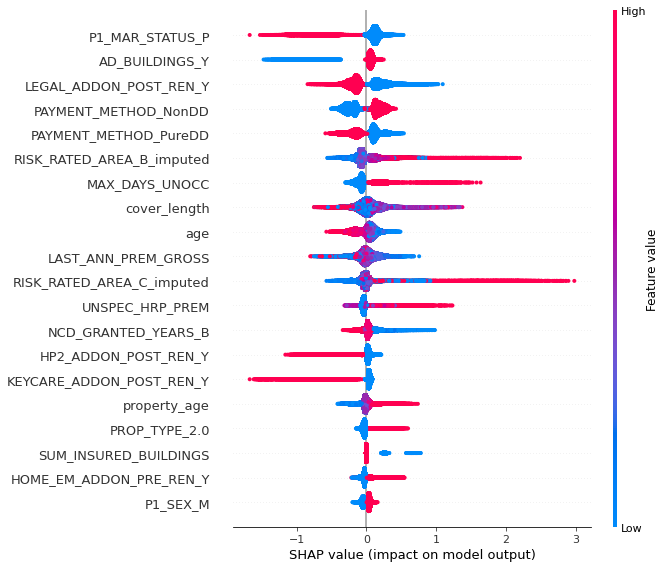

In [86]:
shap_values = shap.TreeExplainer(xgb_model).shap_values(X_train)

shap.summary_plot(shap_values, X_train)

In [28]:
xgb_model.save_model("resources/models/xgb_model-2021-02-14.pkl")

In [29]:
prediction_train = xgb_model.predict(dtrain)
prediction = xgb_model.predict(dtest)

In [65]:
print("Accuracy score for training set is " + str(round(accuracy_score(y_train, 
                                                           np.where(prediction_train > .2776,
                                                                    1, 0)),4)))
print("Accuracy score for test set is " + str(round(accuracy_score(y_test, np.where(prediction > .2776,
                                                                        1, 0)),4)))

Accuracy score for training set is 0.7452
Accuracy score for test set is 0.7013


In [30]:
print("F1 score for training set is " + str(round(f1_score(y_train, 
                                                           np.where(prediction_train > .2776,
                                                                    1, 0)),4)))
print("F1 score for test set is " + str(round(f1_score(y_test, np.where(prediction > .2776,
                                                                        1, 0)),4)))

F1 score for training set is 0.6233
F1 score for test set is 0.5606


In [91]:
print("The size of the dataset is " +
      str(len(df))
     )
print("The size of the training set is " +
      str(len(y_train))
     )
print("The size of the test set is " +
      str(len(y_test))
     )

The size of the dataset is 256136
The size of the training set is 132403
The size of the test set is 56602


In [31]:
confusion_matrix(y_test, np.where(prediction > .2776, 1, 0))

array([[28907, 11972],
       [ 4936, 10787]])

## 1D-CNN model
This architecture is known with supreme predictive power. I was expecting with this model, it will improve the model performance but it was slightly worse than XGBoost model. Also due to time constrain, I didn't have time to fine-tune the model so it might be also the reason. 

In [16]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

y_preds = []
models = []
oof_train = np.zeros((len(X_train),))

for fold_id, (train_index, valid_index) in enumerate(cv.split(X_train, y_train)):
    X_tr = X_train.iloc[train_index, :]
    X_val = X_train.iloc[valid_index, :]
    y_tr = y_train.iloc[train_index]
    y_val = y_train.iloc[valid_index]

    model = keras.Sequential([
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.Dense(4096, activation='relu'),
        layers.Reshape((256, 16)),
        layers.BatchNormalization(),
        layers.Dropout(0.1),
        layers.Conv1D(filters=16, kernel_size=5, strides=1, activation='relu'),
        layers.MaxPooling1D(pool_size=2),
        layers.Flatten(),
        layers.Dense(16, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
    ])

    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=[keras.metrics.BinaryCrossentropy()]
    )

    early_stopping = keras.callbacks.EarlyStopping(
        patience=10,
        min_delta=0.001,
        restore_best_weights=True,
    )

    model.fit(
        X_tr, y_tr,
        validation_data=(X_val, y_val),
        batch_size=10000,
        epochs=100,
        callbacks=[early_stopping],
    )

    oof_train[valid_index] = model.predict(X_val).reshape(1, -1)[0]
    y_pred = model.predict(X_test).reshape(1, -1)[0]

    y_preds.append(y_pred)
    models.append(model)

Epoch 1/100
22/22 [==============================] - 38s 2s/step - loss: 0.6048 - binary_crossentropy: 0.6048 - val_loss: 0.6646 - val_binary_crossentropy: 0.6646
Epoch 2/100
22/22 [==============================] - 20s 910ms/step - loss: 0.5295 - binary_crossentropy: 0.5295 - val_loss: 0.6572 - val_binary_crossentropy: 0.6572
Epoch 3/100
22/22 [==============================] - 20s 906ms/step - loss: 0.5223 - binary_crossentropy: 0.5223 - val_loss: 0.6510 - val_binary_crossentropy: 0.6510
Epoch 4/100
22/22 [==============================] - 20s 890ms/step - loss: 0.5166 - binary_crossentropy: 0.5166 - val_loss: 0.6413 - val_binary_crossentropy: 0.6413
Epoch 5/100
22/22 [==============================] - 21s 956ms/step - loss: 0.5114 - binary_crossentropy: 0.5114 - val_loss: 0.6351 - val_binary_crossentropy: 0.6351
Epoch 6/100
22/22 [==============================] - 20s 905ms/step - loss: 0.5071 - binary_crossentropy: 0.5071 - val_loss: 0.6286 - val_binary_crossentropy: 0.6286
Epoch 7

In [81]:
print("Accuracy score for test set is " + 
      str(round(accuracy_score(y_test, np.where((sum(y_preds) / len(y_preds)) > .2776,
                                                                        1, 0)),4)))

Accuracy score for test set is 0.6371


In [58]:
print("F1 score for test set is " + 
      str(round(f1_score(y_test, np.where((sum(y_preds) / len(y_preds)) > .2776,
                                                                        1, 0)),4)))

F1 score for test set is 0.5376


In [63]:
confusion_matrix(y_test, np.where((sum(y_preds) / len(y_preds)) > .2776, 1, 0))

array([[24122, 16757],
       [ 3784, 11939]])